In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/Cat Emotions.v1-test.folder.zip"
extract_path = "/content/drive/MyDrive/Cat_Emotions"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzip complete")


Unzip complete


In [ ]:
os.listdir("/content/drive/MyDrive/Cat_Emotions")

['README.dataset.txt', 'README.roboflow.txt', 'train', 'valid']

# **Data Analysis**

In [ ]:
import os

DATASET_ROOT = "/content/drive/MyDrive/Cat_Emotions"
TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
VAL_DIR   = os.path.join(DATASET_ROOT, "valid")

print("Train classes:", os.listdir(TRAIN_DIR))
print("Val classes:", os.listdir(VAL_DIR))

Train classes: ['Angry', 'Disgusted', 'Happy', 'Normal', 'Sad', 'Scared', 'Surprised']
Val classes: ['Angry', 'Disgusted', 'Happy', 'Normal', 'Sad', 'Scared', 'Surprised']


In [ ]:
from collections import defaultdict

def count_images(folder):
    counts = {}
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len([
                f for f in os.listdir(cls_path)
                if f.lower().endswith((".jpg", ".jpeg", ".png"))
            ])
    return counts

train_counts = count_images(TRAIN_DIR)
val_counts = count_images(VAL_DIR)

print("TRAIN SET")
for k, v in train_counts.items():
    print(f"{k}: {v}")

print("\nVALIDATION SET")
for k, v in val_counts.items():
    print(f"{k}: {v}")

TRAIN SET
Angry: 70
Disgusted: 61
Happy: 61
Normal: 74
Sad: 63
Scared: 79
Surprised: 94

VALIDATION SET
Angry: 29
Disgusted: 18
Happy: 37
Normal: 24
Sad: 35
Scared: 20
Surprised: 6


# Imbalance Check

In [ ]:
max_count = max(train_counts.values())
min_count = min(train_counts.values())

print("Max images in a class:", max_count)
print("Min images in a class:", min_count)
print("Imbalance ratio:", round(max_count / min_count, 2))

Max images in a class: 94
Min images in a class: 61
Imbalance ratio: 1.54


In [ ]:
classes = sorted(train_counts.keys())
num_classes = len(classes)

print("Classes:", classes)
print("Number of classes:", num_classes)

Classes: ['Angry', 'Disgusted', 'Happy', 'Normal', 'Sad', 'Scared', 'Surprised']
Number of classes: 7


# Imports & Libraries

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# **Defining Image Transformation**


*   Image Resize to 224 x 224
*   Normalization



In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Loading Dataset

In [ ]:
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset   = datasets.ImageFolder(VAL_DIR, transform=val_transforms)

print("Class to index mapping:")
print(train_dataset.class_to_idx)

Class to index mapping:
{'Angry': 0, 'Disgusted': 1, 'Happy': 2, 'Normal': 3, 'Sad': 4, 'Scared': 5, 'Surprised': 6}


# Creating Dataloaders

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

Train batches: 32
Val batches: 11


# Checking Random Image Labels

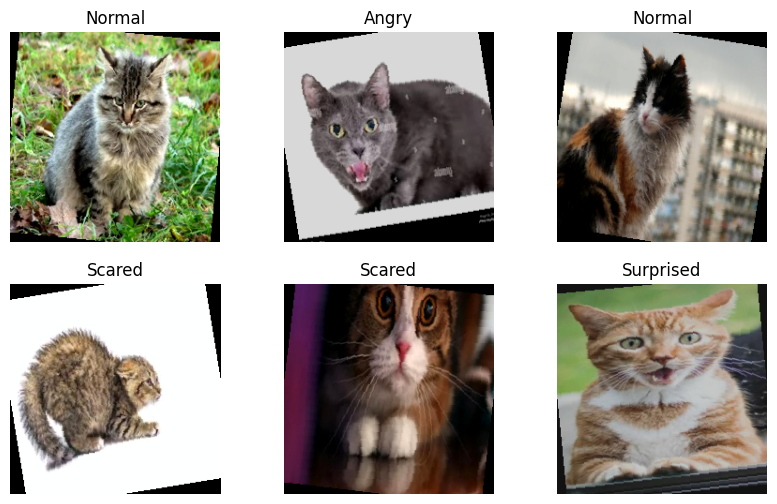

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

inputs, classes_idx = next(iter(train_loader))

plt.figure(figsize=(10, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    imshow(inputs[i])
    ax.set_title(train_dataset.classes[classes_idx[i]])
plt.show()

# **ResNet-18 : Model Architecture**

In [ ]:
from torchvision import models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 85.3MB/s]


In [ ]:
for param in model.parameters():
    param.requires_grad = False


Changing ResNet's Final Layer into a classfier

In [ ]:
num_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)

In [ ]:
model = model.to(device)

# Parameters

In [ ]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())

print(f"Trainable params: {trainable}")
print(f"Total params: {total}")

Trainable params: 133127
Total params: 11309639


# HyperParameter Tuning

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.fc.parameters(),
    lr=1e-3
)

In [ ]:
EPOCHS = 15
best_val_acc = 0.0

history = {
    "train_loss": [],
    "val_loss": [],
    "val_acc": []
}

## **ResNet-18 Training Loop**

In [ ]:
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 30)

    # ===== TRAINING =====
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_dataset)
    history["train_loss"].append(epoch_train_loss)

    print(f"Train Loss: {epoch_train_loss:.4f}")

    # ===== VALIDATION =====
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = correct / total

    history["val_loss"].append(epoch_val_loss)
    history["val_acc"].append(epoch_val_acc)

    print(f"Val Loss: {epoch_val_loss:.4f}")
    print(f"Val Acc:  {epoch_val_acc*100:.2f}%")

    # ===== SAVE BEST MODEL =====
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), "best_cat_emotion_model.pt")
        print("Best model saved")



Epoch 1/15
------------------------------
Train Loss: 1.9279
Val Loss: 2.1295
Val Acc:  11.24%
Best model saved

Epoch 2/15
------------------------------
Train Loss: 1.7511
Val Loss: 1.7052
Val Acc:  37.28%
Best model saved

Epoch 3/15
------------------------------
Train Loss: 1.5743
Val Loss: 1.5881
Val Acc:  39.64%
Best model saved

Epoch 4/15
------------------------------
Train Loss: 1.5158
Val Loss: 1.6420
Val Acc:  37.28%

Epoch 5/15
------------------------------
Train Loss: 1.3821
Val Loss: 1.5544
Val Acc:  40.83%
Best model saved

Epoch 6/15
------------------------------
Train Loss: 1.3674
Val Loss: 1.4610
Val Acc:  49.11%
Best model saved

Epoch 7/15
------------------------------
Train Loss: 1.3116
Val Loss: 1.5576
Val Acc:  43.79%

Epoch 8/15
------------------------------
Train Loss: 1.3116
Val Loss: 1.4370
Val Acc:  43.79%

Epoch 9/15
------------------------------
Train Loss: 1.1633
Val Loss: 1.3626
Val Acc:  45.56%

Epoch 10/15
------------------------------
Train L

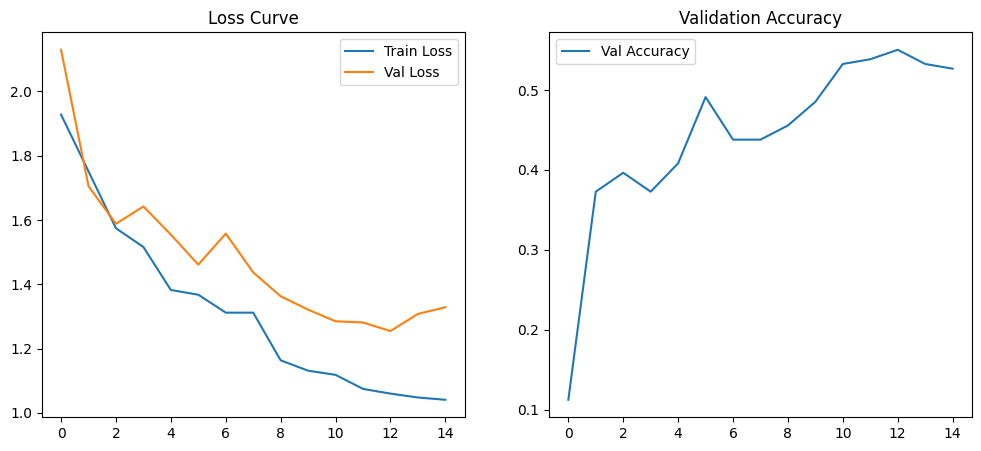

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history["val_acc"], label="Val Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.show()

Final Validation Accuracy: 55.03%


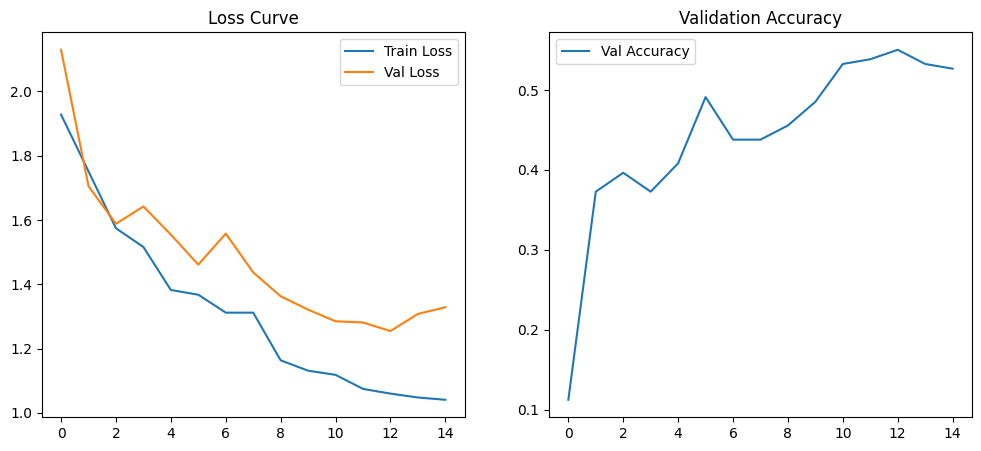

In [ ]:
print(f"Final Validation Accuracy: {best_val_acc*100:.2f}%")

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history["val_acc"], label="Val Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.show()

# **ResNet FineTuning**

In [ ]:
# Freeze everything
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer4
for param in model.layer4.parameters():
    param.requires_grad = True

# Unfreeze classifier
for param in model.fc.parameters():
    param.requires_grad = True


In [ ]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())

print(f"Trainable params: {trainable}")
print(f"Total params: {total}")


Trainable params: 8526855
Total params: 11309639


Decreasing Learning Rate

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(), "lr": 3e-4}
])

### Reducing Learning Rate every 5 epochs to prevent **overfitting**

In [ ]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(
    optimizer,
    step_size=5,
    gamma=0.3
)

In [ ]:
EPOCHS = 10

# Fine Tuned Model Training Loop

In [ ]:
EPOCHS = 10
best_val_acc = 0.0
history = {
    "train_loss": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 30)

    # ===== TRAINING =====
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_dataset)
    history["train_loss"].append(epoch_train_loss)

    print(f"Train Loss: {epoch_train_loss:.4f}")

    # ===== VALIDATION =====
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = correct / total

    history["val_loss"].append(epoch_val_loss)
    history["val_acc"].append(epoch_val_acc)

    print(f"Val Loss: {epoch_val_loss:.4f}")
    print(f"Val Acc:  {epoch_val_acc*100:.2f}%")

    # ===== SAVE BEST MODEL =====
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), "best_cat_emotion_model_finetuned.pt")
        print("Best fine-tuned model saved")

    scheduler.step()


Epoch 1/10
------------------------------
Train Loss: 1.0639
Val Loss: 1.3206
Val Acc:  53.25%
Best fine-tuned model saved

Epoch 2/10
------------------------------
Train Loss: 0.6402
Val Loss: 1.0676
Val Acc:  62.72%
Best fine-tuned model saved

Epoch 3/10
------------------------------
Train Loss: 0.4945
Val Loss: 1.2024
Val Acc:  59.17%

Epoch 4/10
------------------------------
Train Loss: 0.3854
Val Loss: 1.1193
Val Acc:  67.46%
Best fine-tuned model saved

Epoch 5/10
------------------------------
Train Loss: 0.2686
Val Loss: 1.2217
Val Acc:  60.36%

Epoch 6/10
------------------------------
Train Loss: 0.1930
Val Loss: 1.1470
Val Acc:  61.54%

Epoch 7/10
------------------------------
Train Loss: 0.2046
Val Loss: 1.1066
Val Acc:  63.91%

Epoch 8/10
------------------------------
Train Loss: 0.1371
Val Loss: 1.0920
Val Acc:  62.72%

Epoch 9/10
------------------------------
Train Loss: 0.1482
Val Loss: 1.1211
Val Acc:  60.36%

Epoch 10/10
------------------------------
Train Lo

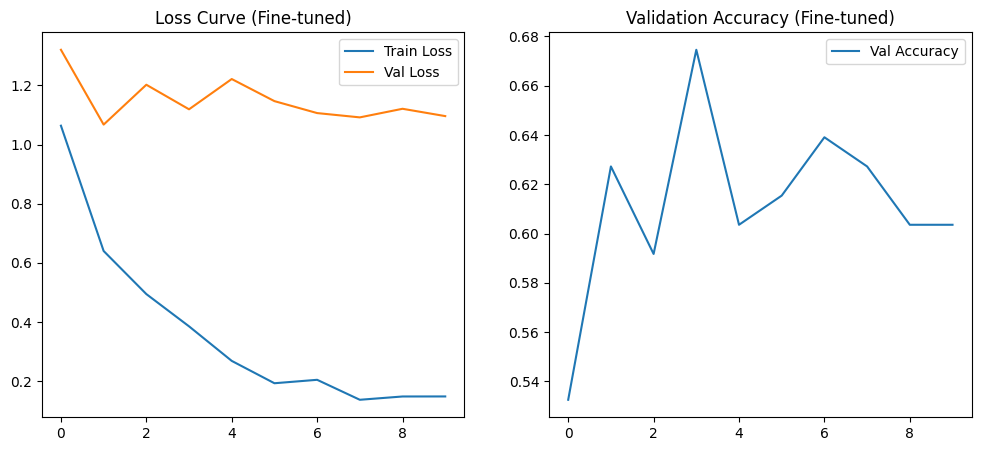

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve (Fine-tuned)")

plt.subplot(1,2,2)
plt.plot(history["val_acc"], label="Val Accuracy")
plt.legend()
plt.title("Validation Accuracy (Fine-tuned)")

plt.show()

# Augmenting the Dataset to Improve performance

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import InterpolationMode

IMAGE_SIZE = 224
BATCH_SIZE = 16

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0), interpolation=InterpolationMode.BICUBIC),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomAffine(15, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=15, interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset   = datasets.ImageFolder(VAL_DIR, transform=val_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Datasets and DataLoaders reloaded with updated transformations.")

Datasets and DataLoaders reloaded with updated transformations.


In [ ]:
EPOCHS = 8
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 30)

    # ===== TRAINING =====
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_dataset)
    history["train_loss"].append(epoch_train_loss)

    print(f"Train Loss: {epoch_train_loss:.4f}")

    # ===== VALIDATION =====
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = correct / total

    history["val_loss"].append(epoch_val_loss)
    history["val_acc"].append(epoch_val_acc)

    print(f"Val Loss: {epoch_val_loss:.4f}")
    print(f"Val Acc:  {epoch_val_acc*100:.2f}%")

    # ===== SAVE BEST MODEL =====
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), "best_cat_emotion_model_finetuned.pt")
        print("Best fine-tuned model saved")

    scheduler.step()


Epoch 1/8
------------------------------
Train Loss: 0.4317
Val Loss: 1.1223
Val Acc:  63.31%

Epoch 2/8
------------------------------
Train Loss: 0.3864
Val Loss: 1.1968
Val Acc:  62.13%

Epoch 3/8
------------------------------
Train Loss: 0.3658
Val Loss: 1.1635
Val Acc:  62.72%

Epoch 4/8
------------------------------
Train Loss: 0.3425
Val Loss: 1.2833
Val Acc:  58.58%

Epoch 5/8
------------------------------
Train Loss: 0.3727
Val Loss: 1.1728
Val Acc:  61.54%

Epoch 6/8
------------------------------
Train Loss: 0.3228
Val Loss: 1.1802
Val Acc:  60.36%

Epoch 7/8
------------------------------
Train Loss: 0.3268
Val Loss: 1.1331
Val Acc:  60.95%

Epoch 8/8
------------------------------
Train Loss: 0.3477
Val Loss: 1.1467
Val Acc:  63.31%


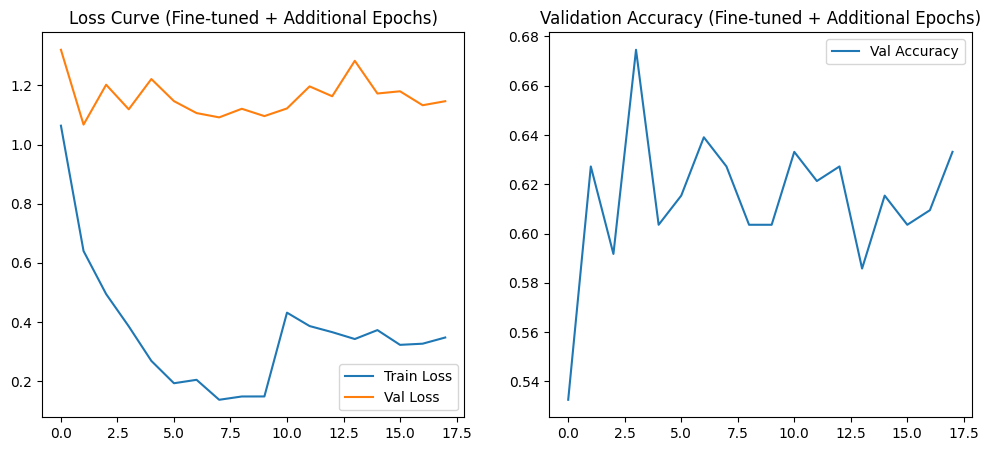

Best Validation Accuracy after all training: 67.46%


In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve (Fine-tuned + Additional Epochs)")

plt.subplot(1,2,2)
plt.plot(history["val_acc"], label="Val Accuracy")
plt.legend()
plt.title("Validation Accuracy (Fine-tuned + Additional Epochs)")

plt.show()
print(f"Best Validation Accuracy after all training: {best_val_acc*100:.2f}%")

# **EfficientNet B0 : Model Architecture**

In [ ]:
from torchvision import models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[1].in_features

model.classifier = nn.Linear(num_features, num_classes)

model = model.to(device)

print("EfficientNet-B0 loaded, backbone frozen, and classifier replaced.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 101MB/s] 


EfficientNet-B0 loaded, backbone frozen, and classifier replaced.


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.classifier.parameters(),
    lr=1e-3
)

EPOCHS = 6
best_val_acc = 0.0

history = {
    "train_loss": [],
    "val_loss": [],
    "val_acc": []
}

print("Starting first phase training (classifier head only)...")

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 30)

    # ===== TRAINING =====
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_dataset)
    history["train_loss"].append(epoch_train_loss)

    print(f"Train Loss: {epoch_train_loss:.4f}")

    # ===== VALIDATION =====
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = correct / total

    history["val_loss"].append(epoch_val_loss)
    history["val_acc"].append(epoch_val_acc)

    print(f"Val Loss: {epoch_val_loss:.4f}")
    print(f"Val Acc:  {epoch_val_acc*100:.2f}%")

    # ===== SAVE BEST MODEL =====
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), "best_efficientnet_cat_emotion_classifier_only.pt")
        print("Best model (classifier only) saved")

print("\nFirst phase training complete.")

Starting first phase training (classifier head only)...

Epoch 1/6
------------------------------
Train Loss: 1.9237
Val Loss: 1.8562
Val Acc:  20.12%
Best model (classifier only) saved

Epoch 2/6
------------------------------
Train Loss: 1.6638
Val Loss: 1.7245
Val Acc:  34.32%
Best model (classifier only) saved

Epoch 3/6
------------------------------
Train Loss: 1.5187
Val Loss: 1.6371
Val Acc:  41.42%
Best model (classifier only) saved

Epoch 4/6
------------------------------
Train Loss: 1.4026
Val Loss: 1.5831
Val Acc:  44.38%
Best model (classifier only) saved

Epoch 5/6
------------------------------
Train Loss: 1.3363
Val Loss: 1.5708
Val Acc:  46.75%
Best model (classifier only) saved

Epoch 6/6
------------------------------
Train Loss: 1.2777
Val Loss: 1.4989
Val Acc:  52.07%
Best model (classifier only) saved

First phase training complete.


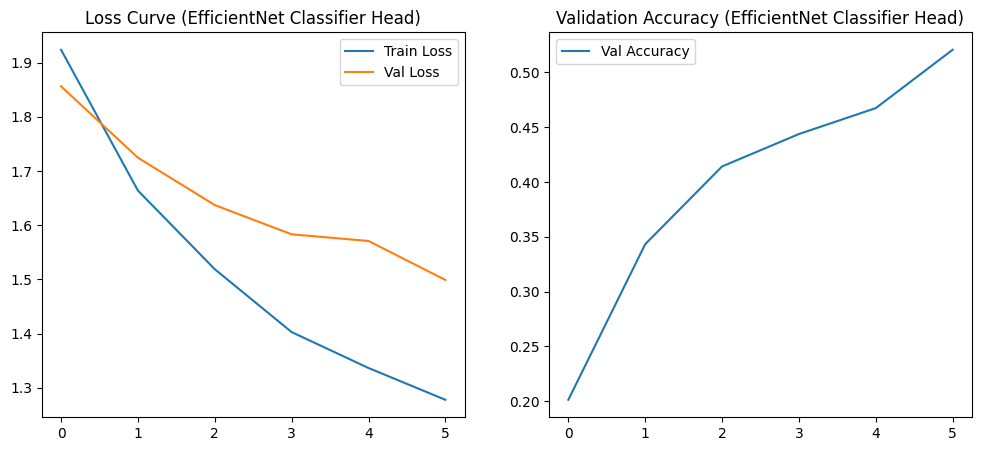

Best Validation Accuracy after classifier head training: 52.07%


In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve (EfficientNet Classifier Head)")

plt.subplot(1,2,2)
plt.plot(history["val_acc"], label="Val Accuracy")
plt.legend()
plt.title("Validation Accuracy (EfficientNet Classifier Head)")

plt.show()

print(f"Best Validation Accuracy after classifier head training: {best_val_acc*100:.2f}%")

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for i in range(5, 8):
    for param in model.features[i].parameters():
        param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

print("EfficientNet-B0 layers unfrozen for fine-tuning.")

EfficientNet-B0 layers unfrozen for fine-tuning.


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([
    {"params": model.features[5].parameters(), "lr": 1e-5},
    {"params": model.features[6].parameters(), "lr": 1e-5},
    {"params": model.features[7].parameters(), "lr": 1e-5},
    {"params": model.classifier.parameters(), "lr": 1e-4}
])

scheduler = StepLR(
    optimizer,
    step_size=3,
    gamma=0.5
)

EPOCHS = 10

print("Optimizer and LR scheduler set up for fine-tuning. Starting second phase training...")

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 30)

    # ===== TRAINING =====
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_dataset)
    history["train_loss"].append(epoch_train_loss)

    print(f"Train Loss: {epoch_train_loss:.4f}")

    # ===== VALIDATION =====
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = correct / total

    history["val_loss"].append(epoch_val_loss)
    history["val_acc"].append(epoch_val_acc)

    print(f"Val Loss: {epoch_val_loss:.4f}")
    print(f"Val Acc:  {epoch_val_acc*100:.2f}%")

    # ===== SAVE BEST MODEL =====
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), "best_efficientnet_cat_emotion_finetuned.pt")
        print("Best fine-tuned model saved")

    scheduler.step()

print("\nSecond phase training complete.")

Optimizer and LR scheduler set up for fine-tuning. Starting second phase training...

Epoch 1/10
------------------------------
Train Loss: 1.2445
Val Loss: 1.4943
Val Acc:  53.25%
Best fine-tuned model saved

Epoch 2/10
------------------------------
Train Loss: 1.2230
Val Loss: 1.4730
Val Acc:  50.89%

Epoch 3/10
------------------------------
Train Loss: 1.1878
Val Loss: 1.4588
Val Acc:  52.07%

Epoch 4/10
------------------------------
Train Loss: 1.1660
Val Loss: 1.4487
Val Acc:  53.25%

Epoch 5/10
------------------------------
Train Loss: 1.1080
Val Loss: 1.4366
Val Acc:  53.25%

Epoch 6/10
------------------------------
Train Loss: 1.1608
Val Loss: 1.4447
Val Acc:  52.07%

Epoch 7/10
------------------------------
Train Loss: 1.0846
Val Loss: 1.4470
Val Acc:  52.07%

Epoch 8/10
------------------------------
Train Loss: 1.1199
Val Loss: 1.4339
Val Acc:  51.48%

Epoch 9/10
------------------------------
Train Loss: 1.1026
Val Loss: 1.4323
Val Acc:  53.85%
Best fine-tuned model s

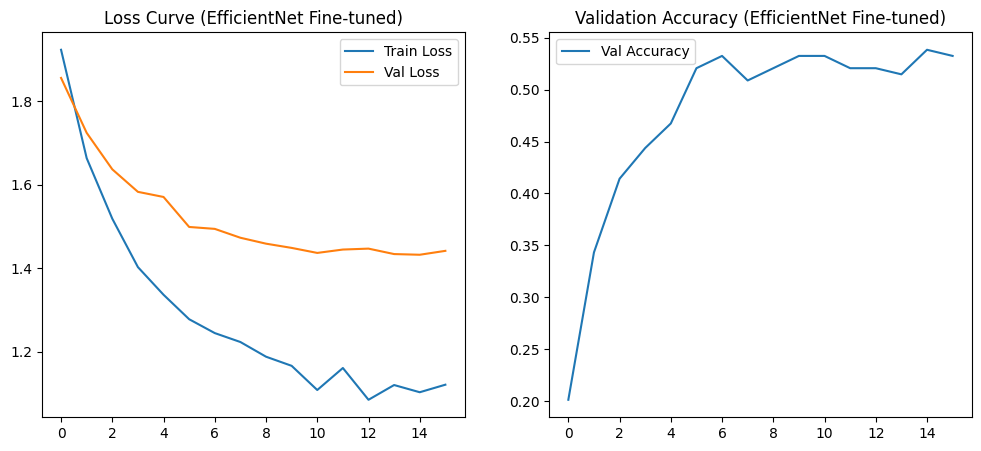

Best Validation Accuracy after all EfficientNet training: 53.85%


In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve (EfficientNet Fine-tuned)")

plt.subplot(1,2,2)
plt.plot(history["val_acc"], label="Val Accuracy")
plt.legend()
plt.title("Validation Accuracy (EfficientNet Fine-tuned)")

plt.show()

print(f"Best Validation Accuracy after all EfficientNet training: {best_val_acc*100:.2f}%")

In [ ]:
from torchvision import models
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)
model = model.to(device)

print("ResNet-18 model re-initialized with custom classifier head and moved to device.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet-18 model re-initialized with custom classifier head and moved to device.


**Reasoning**:
Now that the ResNet-18 model structure is re-initialized, the next logical step is to load the previously saved fine-tuned weights to restore the model's trained state for evaluation.



In [ ]:
model.load_state_dict(torch.load("best_cat_emotion_model_finetuned.pt"))
model.eval()

print("Loaded fine-tuned model weights and set model to evaluation mode.")

Loaded fine-tuned model weights and set model to evaluation mode.


In [ ]:
model.eval()

correct = 0
total = 0
val_loss = 0.0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

epoch_val_loss = val_loss / len(val_dataset)
epoch_val_acc = correct / total

print(f"Validation Loss: {epoch_val_loss:.4f}")
print(f"Validation Accuracy: {epoch_val_acc*100:.2f}%")

Validation Loss: 1.1193
Validation Accuracy: 67.46%


In [ ]:
from PIL import Image
import torch.nn.functional as F

def predict_emotion_single_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transformed_image = val_transforms(image)
    transformed_image = transformed_image.unsqueeze(0)
    transformed_image = transformed_image.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(transformed_image)
    probabilities = F.softmax(outputs, dim=1)
    predicted_prob, predicted_idx = torch.max(probabilities, 1)
    predicted_emotion_label = train_dataset.classes[predicted_idx.item()]
    return predicted_emotion_label, predicted_prob.item()

In [ ]:
test_image_path = '/content/download (1).jpg'
predict_emotion_single_image(test_image_path)

('Disgusted', 0.4650075137615204)

In [ ]:
predict_emotion_single_image(test_image_path)

('Angry', 0.5014622211456299)